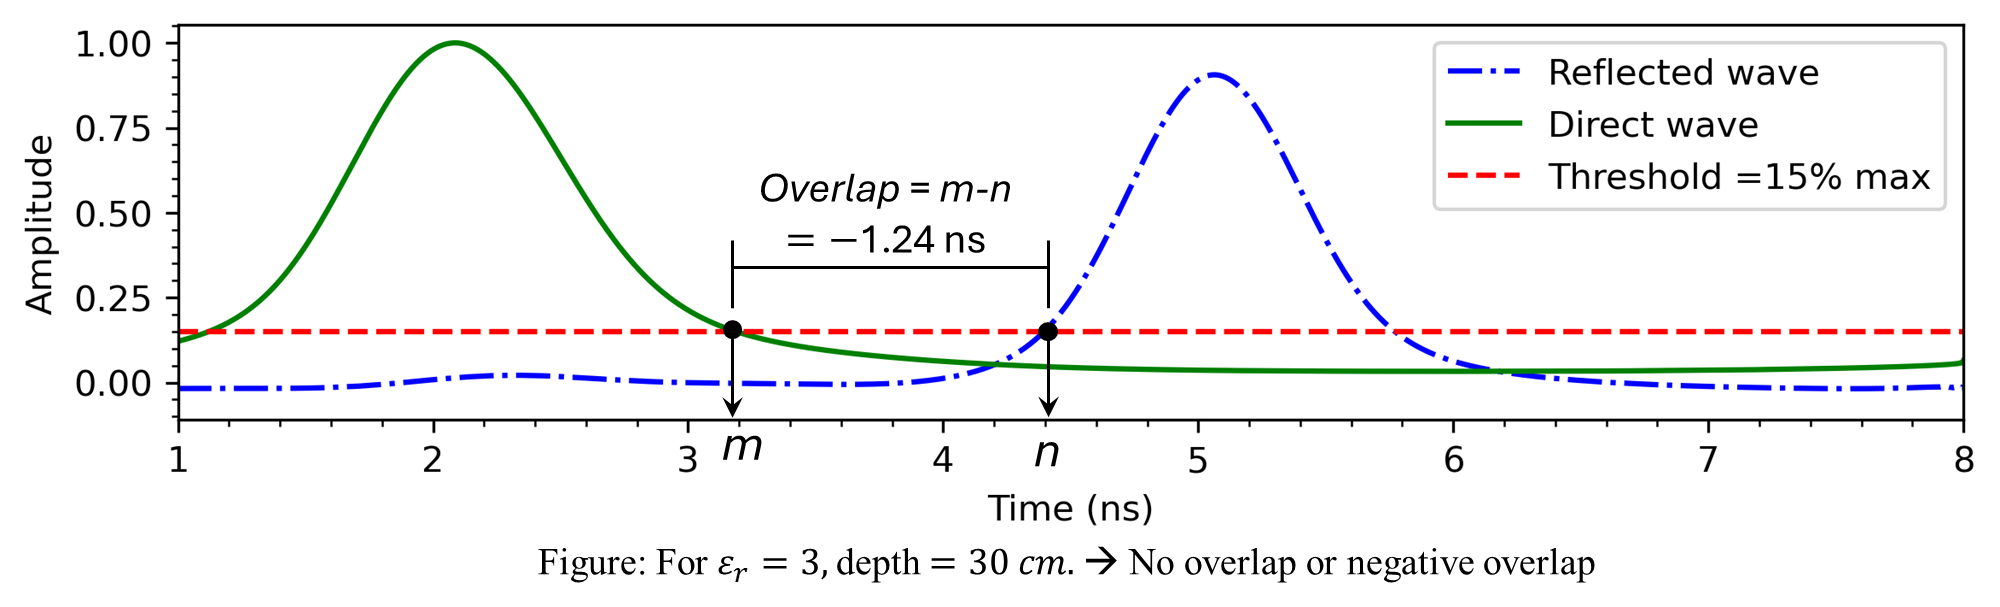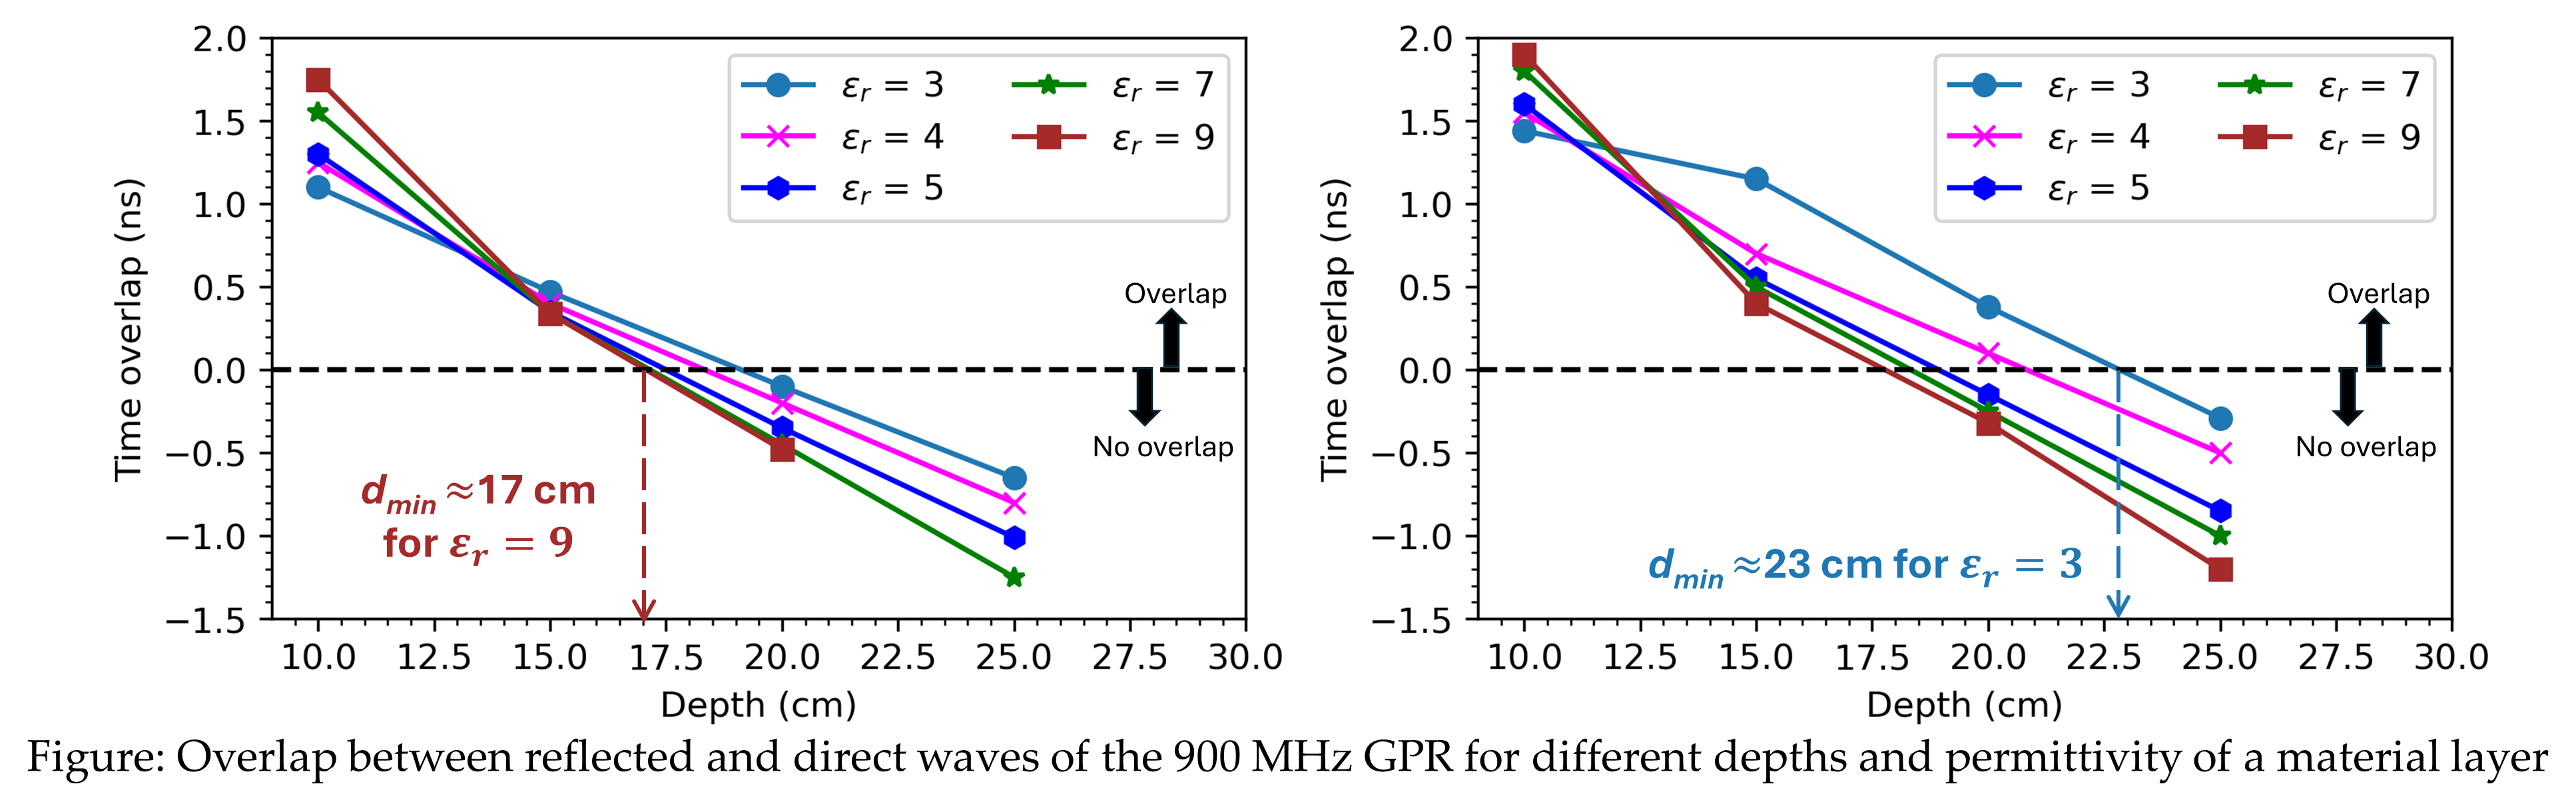

# Packages and Utility functions

#### All necessary packages and gprMax need to be installed to run the following codes

In [1]:
import numpy as np; 
import pandas as pd; 
import matplotlib.pyplot as plt; 
plt.rcParams['figure.figsize'] = (10, 2);
from gprMax.utilities import detect_check_gpus; 
from gprMax.gprMax import api; 
import h5py; 
detect_check_gpus([1]);
import os; 
import torch
import time; 
from IPython.display import clear_output; 
os.getcwd(); 
from GPUtil import showUtilization as gpu_usage
from numba import cuda; 
import gc; 
import pycuda.driver; 
import random; 
from scipy.signal import hilbert
from bayes_opt import BayesianOptimization; 

def free_gpu_cache():
    gc.collect(); 
    torch.cuda.empty_cache(); 
    cuda.select_device(1); 
    cuda.close(); 
    cuda.select_device(1); 
    gpu_usage()
free_gpu_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def norm(signal):
    signal = np.abs(hilbert(signal))    
    return signal

| ID | GPU | MEM |
------------------
|  0 | 10% |  1% |
|  1 | 72% | 55% |


# Minimum depth of investigation for 900 MHz GPR

## Function for 900 MHz calibrated model

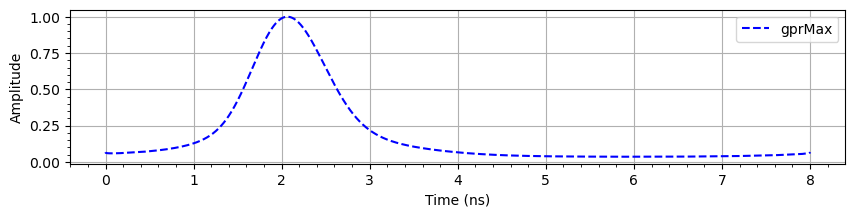

In [2]:
## --------------------------------------------------900 MHz--------------------------------------------------
tw=8e-9; 
def model_900(p1, depth):
    X=0.4; H=0.44; dx=0.001; Y=0.5; Z=dx; b=H-depth; Tx = (X/2)-(0.155/2); dd=0.011
    gpr_Y = H+dd; freq = 0.7e9; 
    with open("Dep.in", "w") as f:
        f.write(f"#title: Soil_15cm + PEC \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} 0.001 1 0 mat1 \n#material: {1.077} {0.015} 1 0 mat2")
        f.write(f"\n#waveform: gaussian 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+0.153} {gpr_Y} 0")
        f.write(f"\n#box: 0 0 0 {X} {H} {Z} mat1")
        f.write(f"\n#box: 0 {H} 0 {X} {H+2*dd} {Z} mat2") 
        f.write(f"\n#box: 0 0 0 {X} {b} {Z} pec")
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Dep n\n")
        f.close()

    api("Dep.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Dep.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:];    hf2.close();    free_gpu_cache(); clear_output()
    return Ascan


sim = model_900(1, 0.15)
sim=np.abs(hilbert(sim)); 
sim=sim/max(sim)

# Plot the two results
t = np.linspace(0, tw, sim.shape[0]) *1e9

plt.figure(figsize=(10, 2))
plt.plot(t,sim,color='blue',label='gprMax', linestyle='--'); 
plt.grid(); 
plt.minorticks_on()
plt.xlabel('Time (ns)'); 
plt.ylabel('Amplitude'); 
plt.legend(); 
plt.show()

## --------------------------------------------------900 MHz Direct-Wave Only--------------------------------------------------
tw=8e-9; 
def model_900_DW(p1, depth):
    X=0.4; H=0.44; dx=0.001; Y=0.5; Z=dx; b=H-depth; Tx = (X/2)-(0.155/2); dd=0.011
    gpr_Y = H+dd; freq = 0.7e9; 
    with open("Dep.in", "w") as f:
        f.write(f"#title: Soil_15cm + PEC \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} 0.001 1 0 mat1 \n#material: {1.077} {0.015} 1 0 mat2")
        f.write(f"\n#waveform: gaussian 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+0.153} {gpr_Y} 0")
        f.write(f"\n#box: 0 0 0 {X} {H} {Z} mat1")
        f.write(f"\n#box: 0 {H} 0 {X} {H+2*dd} {Z} mat2") 
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Dep n\n")
        f.close()

    api("Dep.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Dep.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:];    hf2.close();    free_gpu_cache(); clear_output()
    return Ascan

sim = model_900_DW(3, 0.35)
sim=np.abs(hilbert(sim)); 
sim=sim/max(sim)

# Plot the two results
t = np.linspace(0, tw, sim.shape[0]) *1e9

plt.figure(figsize=(10, 2))
plt.plot(t,
         sim,
         color='blue',
         label='gprMax', 
         linestyle='--'); 
plt.grid(); 
plt.minorticks_on()
plt.xlabel('Time (ns)'); 
plt.ylabel('Amplitude');
plt.legend(); 
plt.show();

## Full A-scan

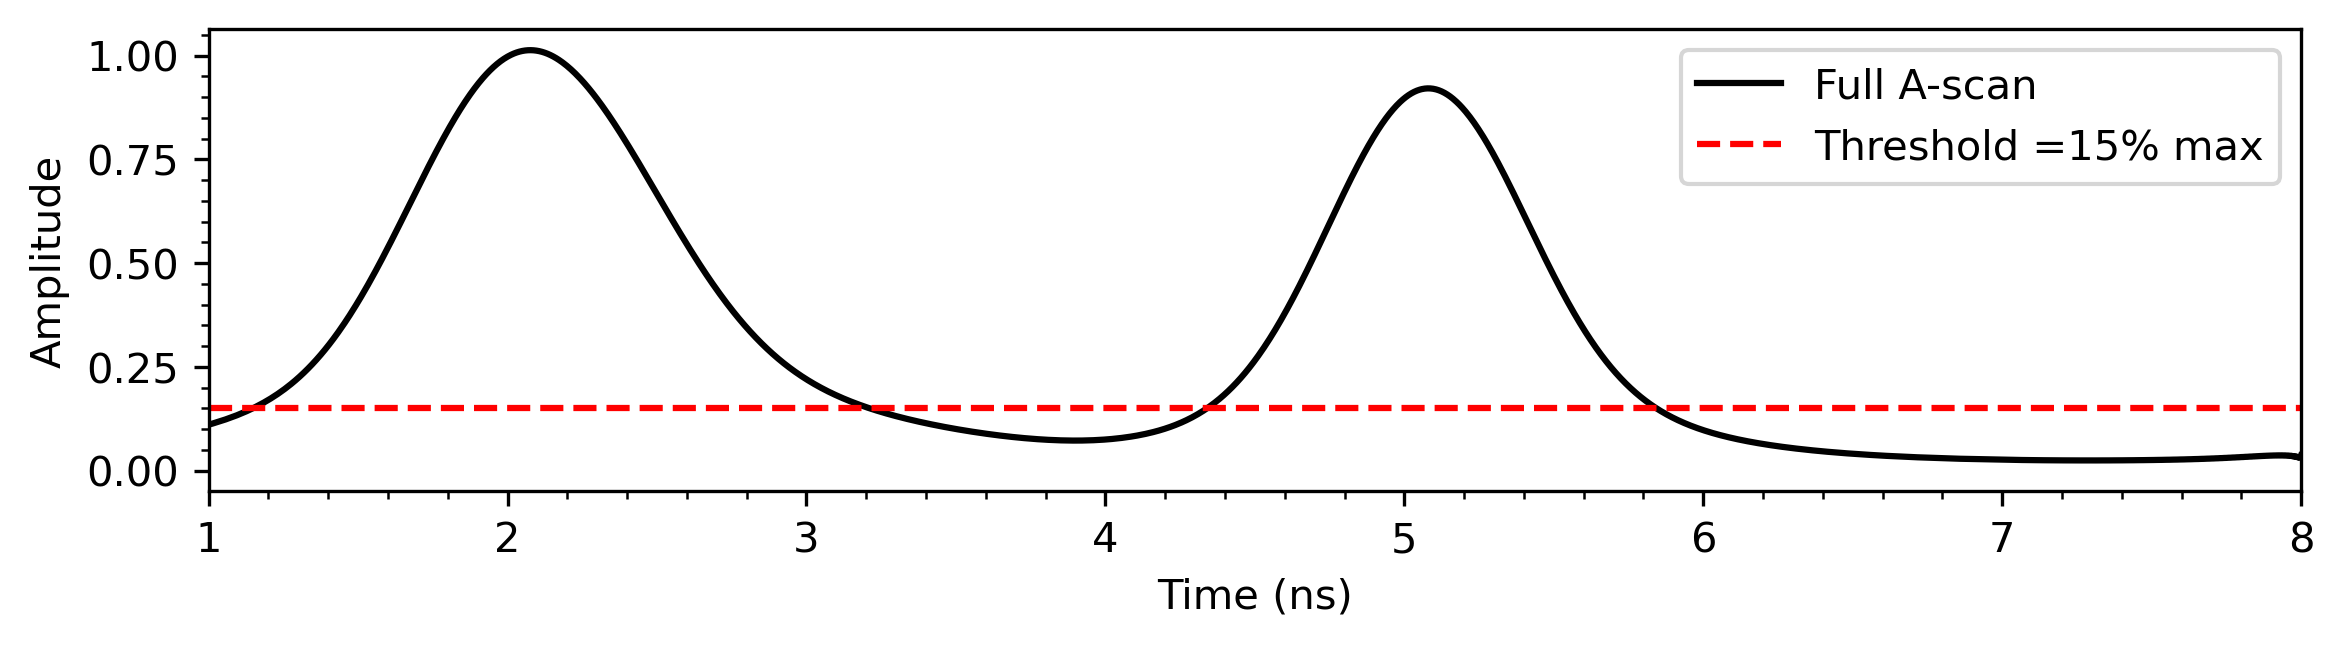

In [3]:
# Full A-scan
perm=3; 
dep=0.30

sim     = model_900(perm,dep)
sim_DW  = model_900_DW(perm,dep)

sim     = np.abs(hilbert(sim)); 
sim_DW  = np.abs(hilbert(sim_DW)); 

sim     = sim/max(sim_DW); 
sim_DW  = sim_DW/max(sim_DW)

# Plot the two results
t = np.linspace(0, tw, sim.shape[0]) *1e9

plt.figure(figsize=(9,2), dpi=300)
plt.plot(t,sim,color='black',label='Full A-scan'); 
plt.axhline(y=0.15 * max(sim_DW), color='r', linestyle='--', label='Threshold =15% max')
plt.minorticks_on();
plt.xlabel('Time (ns)'); 
plt.xlim([1,8]);
plt.ylabel('Amplitude'); 
plt.legend(loc='upper right'); 
plt.show()

## Separated reflected and direct wave

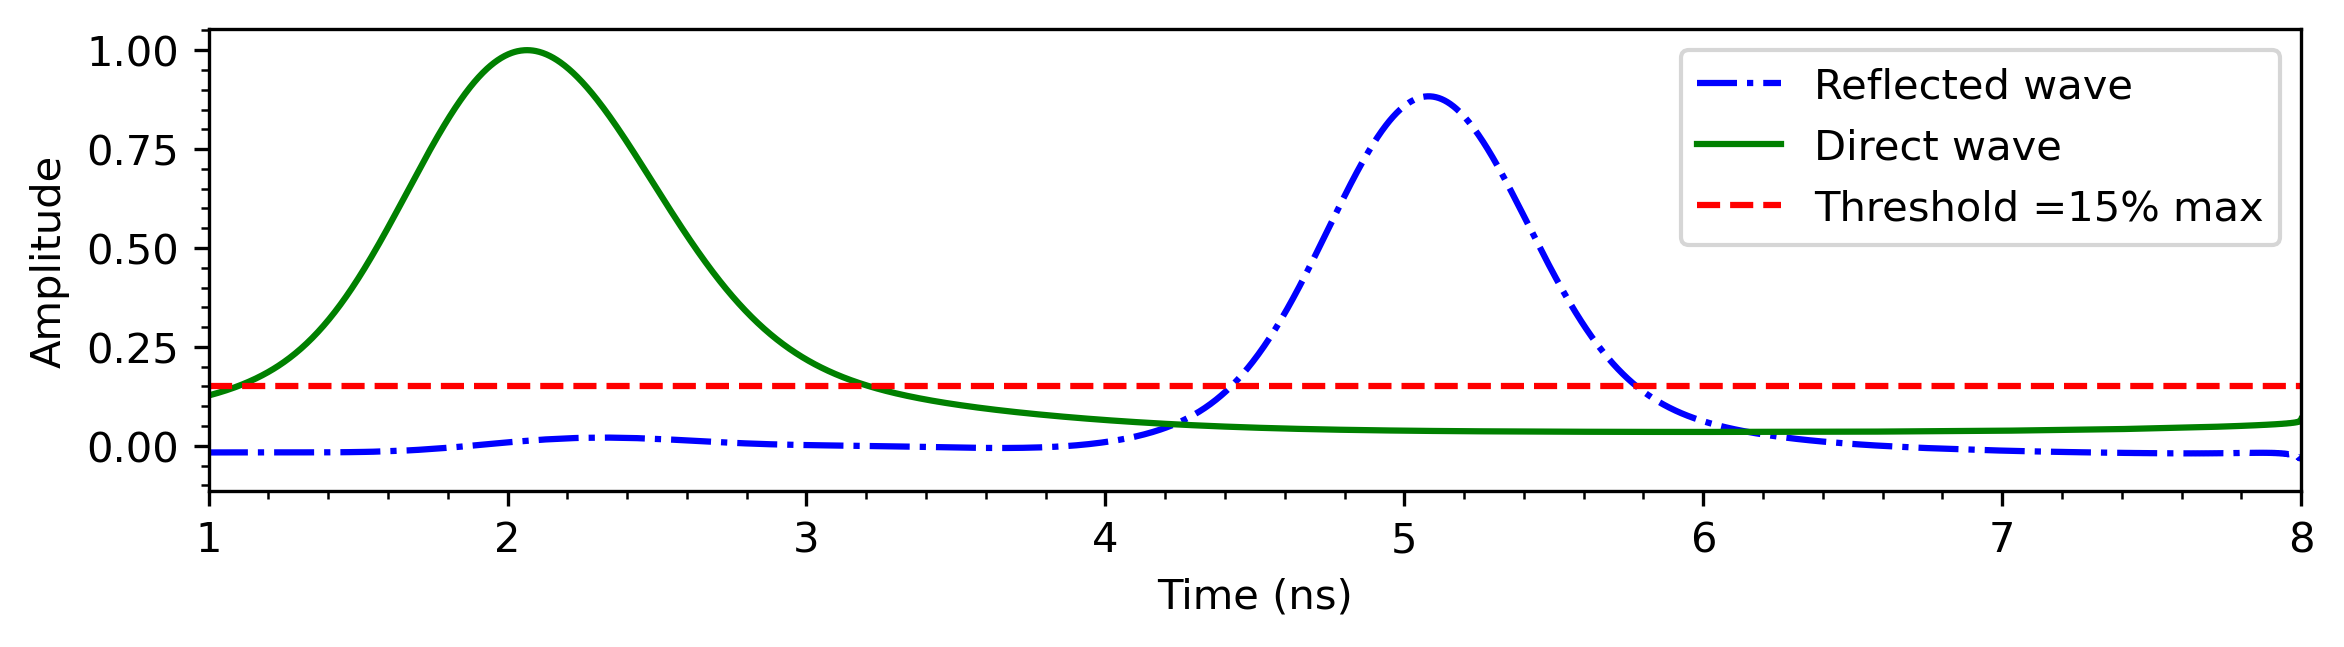

In [4]:
perm=3; 
dep=0.30

sim = model_900(perm,dep)
sim_DW = model_900_DW(perm,dep)

sim=np.abs(hilbert(sim)); 
sim_DW=np.abs(hilbert(sim_DW)); 

sim=sim-sim_DW

sim=sim/max(sim_DW); 
sim_DW=sim_DW/max(sim_DW)

# Plot the two results
t = np.linspace(0, tw, sim.shape[0]) *1e9

plt.figure(figsize=(9,2), dpi=300)
plt.plot(t,sim,color='blue',label='Reflected wave', linestyle='-.'); 
plt.plot(t,sim_DW,color='green',label='Direct wave', linestyle='-'); 
plt.axhline(y=0.15 * max(sim_DW), color='r', linestyle='--', label='Threshold =15% max')
plt.minorticks_on(); 
plt.xlim([1,8]);
plt.xlabel('Time (ns)');
plt.ylabel('Amplitude');
plt.legend(loc='upper right');
plt.show()

The calculated overlap for permittivity=3 & depth=0.30 shown above is about -1.24 ns, which indicates no overlap.

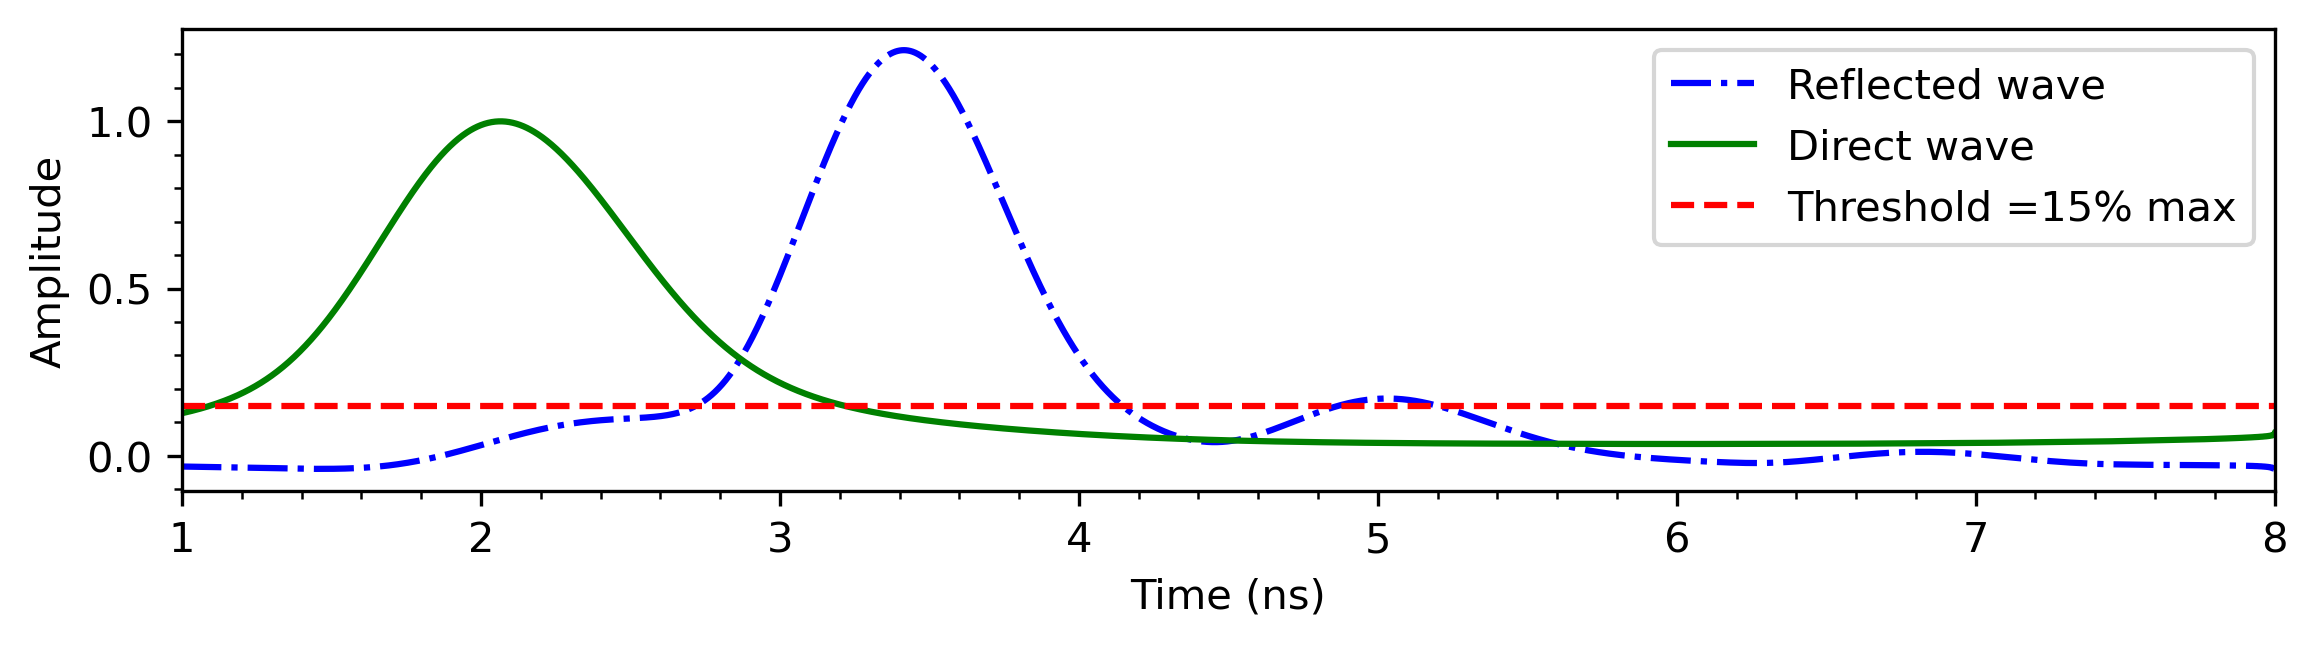

In [5]:
perm = 3; 
dep = 0.15

sim = model_900(perm,dep)
sim_DW = model_900_DW(perm,dep)

sim = np.abs(hilbert(sim)); 
sim_DW = np.abs(hilbert(sim_DW)); 

sim = sim-sim_DW

sim = sim/max(sim_DW); 
sim_DW = sim_DW/max(sim_DW)

# Plot the two results
t = np.linspace(0, tw, sim.shape[0]) *1e9

plt.figure(figsize=(9,2), dpi=300)
plt.plot(t,sim,color='blue',label='Reflected wave', linestyle='-.'); 
plt.plot(t,sim_DW,color='green',label='Direct wave', linestyle='-'); 
plt.axhline(y=0.15 * max(sim_DW), color='r', linestyle='--', label='Threshold =15% max')
plt.minorticks_on(); 
plt.xlim([1,8]);
plt.xlabel('Time (ns)');
plt.ylabel('Amplitude');
plt.legend(loc='upper right');
plt.show()

The calculated overlap for permittivity=3 & depth=0.15 shown above is about 0.45 ns.

## Results

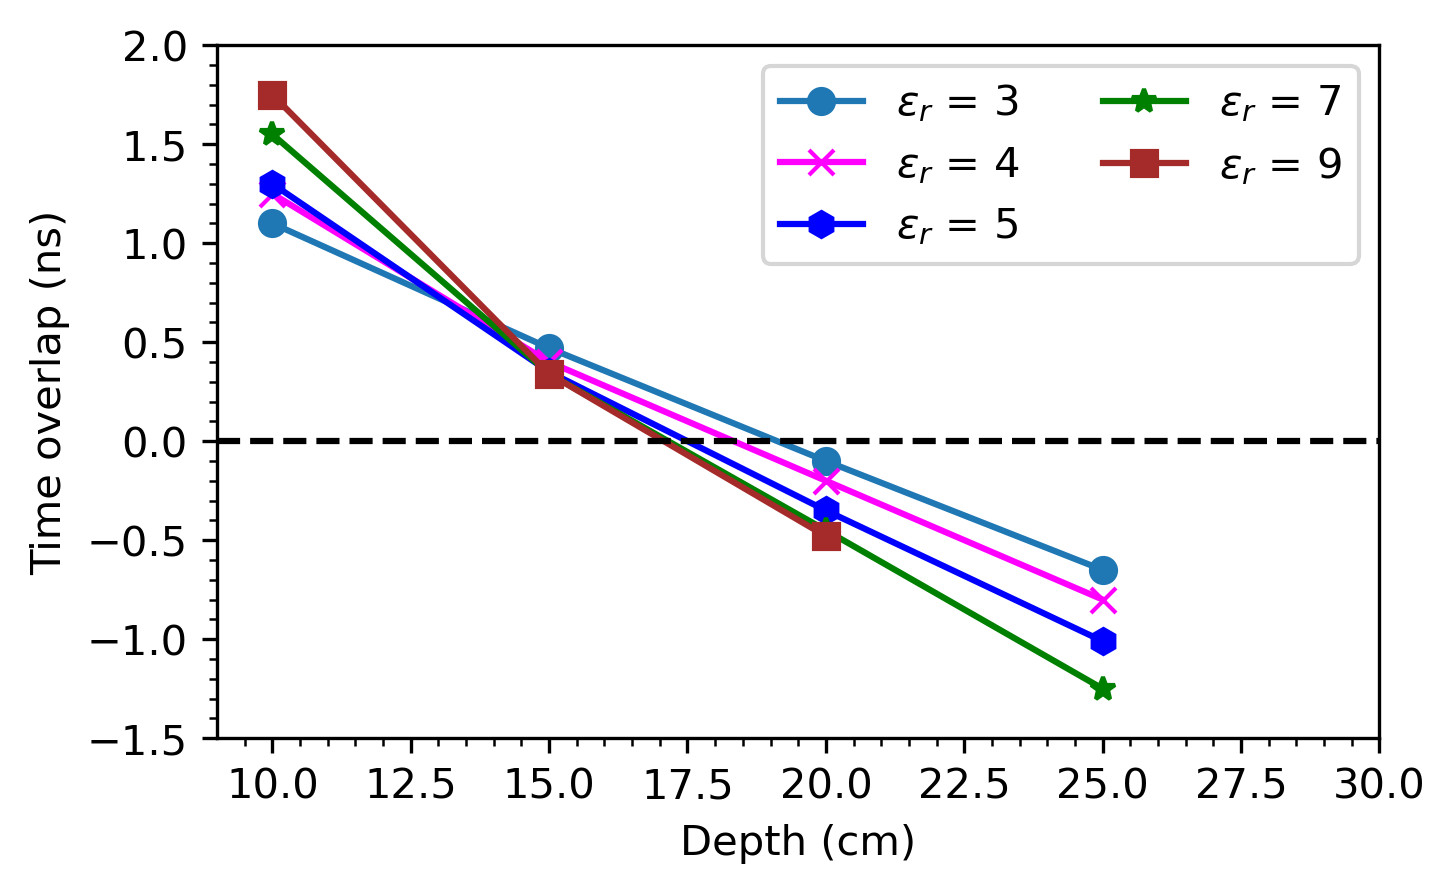

In [6]:
#900MHz, 15 % threshold

d3   = [10,15,20,25]
ol3 = [1.1, 0.47, -0.1, -0.65]

d4   = [10,15,20,25]
ol4 = [1.25,0.4,-.2, -.8]

d5   = [10,15,20,25,]
ol5 = [1.3, .35, -.35, -1.01]

d7   = [10,15,20, 25]
ol7 = [1.55, .34, -.45, -1.25]

d9   = [10,15,20]
ol9 = [1.75,0.34,-.48]


plt.figure(figsize=(5,3), dpi=300)

plt.plot(d3, ol3, label=r'$\epsilon_r$ = 3', marker='o') 
plt.plot(d4, ol4, label=r'$\epsilon_r$ = 4', marker='x', color='magenta') 
plt.plot(d5, ol5, label=r'$\epsilon_r$ = 5', marker='h', color='b') 
plt.plot(d7, ol7, label=r'$\epsilon_r$ = 7', marker='*', color='g') 
plt.plot(d9, ol9, label=r'$\epsilon_r$ = 9', marker='s', color='brown') 

plt.axhline(y=0, color='black', linestyle='--'); 

plt.xlim([9, 30]);
plt.ylim([-1.5, 2.0])
plt.xlabel('Depth (cm)'); 
plt.ylabel('Time overlap (ns)');  
plt.minorticks_on(); 
plt.legend(ncol=2, loc='upper right');
plt.show();

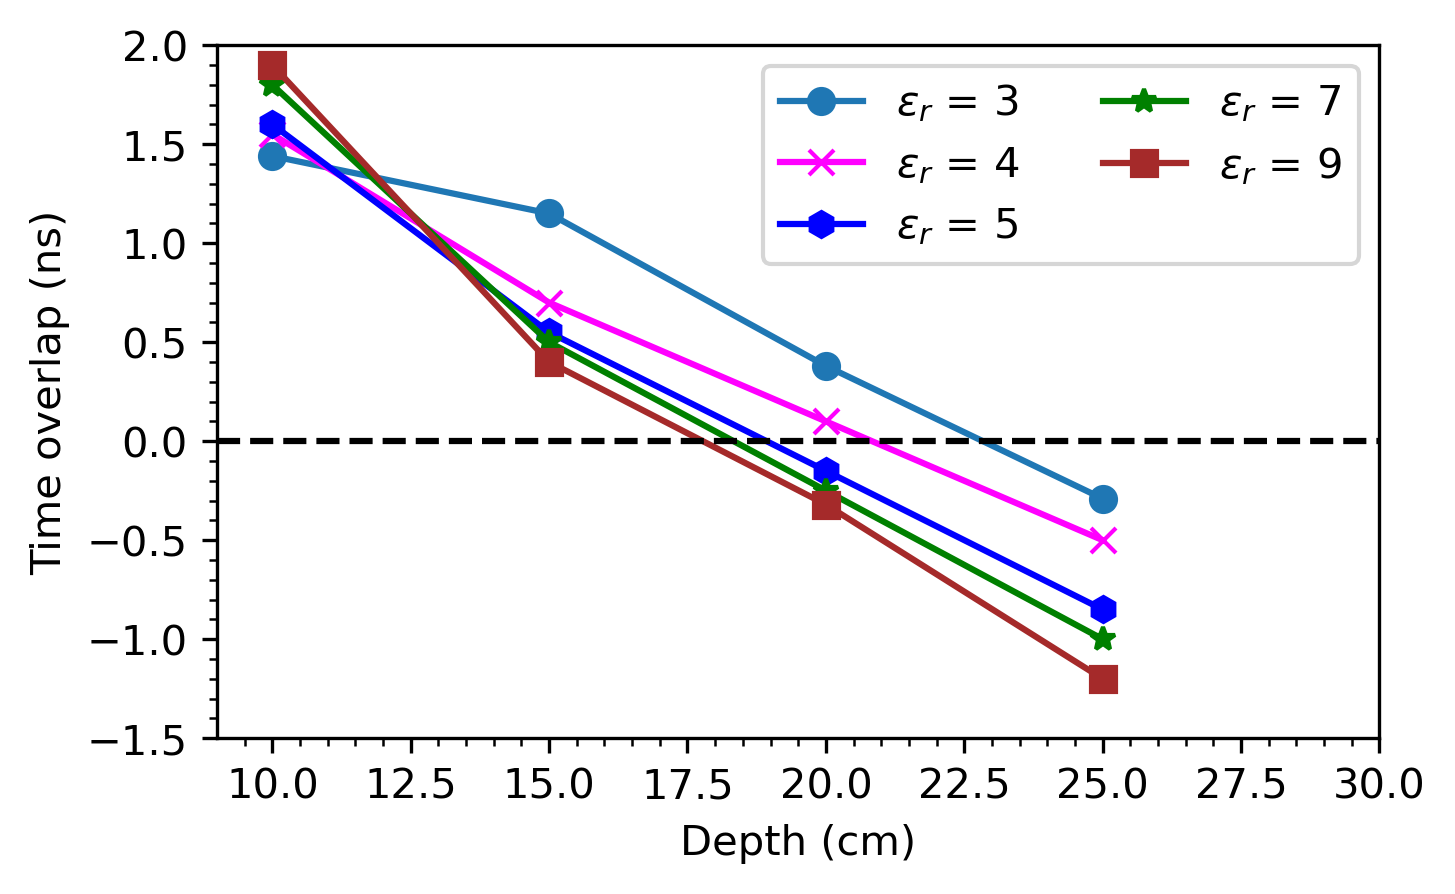

In [7]:
#900MHz, perm=3; 10 % threshold

d3   = [10,15,20,25]
ol3 = [1.44, 1.15, .38, -.29]

d4   = [10,15,20,25]
ol4 = [1.55, 0.7, 0.1, -0.5]

d5   = [10,15,20,25,]
ol5 = [1.6, .55, -.15, -.85]
d7   = [10,15,20, 25]
ol7 = [1.8, 0.5, -.25, -1.]
d9   = [10,15,20, 25]
ol9 = [1.9, 0.4, -0.32,-1.2]


plt.figure(figsize=(5,3), dpi=300)

plt.plot(d3, ol3, label=r'$\epsilon_r$ = 3', marker='o') 
plt.plot(d4, ol4, label=r'$\epsilon_r$ = 4', marker='x', color='magenta') 
plt.plot(d5, ol5, label=r'$\epsilon_r$ = 5', marker='h', color='b') 
plt.plot(d7, ol7, label=r'$\epsilon_r$ = 7', marker='*', color='g') 
plt.plot(d9, ol9, label=r'$\epsilon_r$ = 9', marker='s', color='brown') 

plt.axhline(y=0, color='black', linestyle='--'); 

plt.xlim([9, 30]);
plt.ylim([-1.5, 2.0])
plt.xlabel('Depth (cm)'); 
plt.ylabel('Time overlap (ns)');  
plt.minorticks_on(); 
plt.legend(ncol=2, loc='upper right');
plt.show();